# レスラー方程式(ランダムなシフト付きsin外力のある状態)

レスラー方程式の外力のある場合に関して，$\sin$ 波に位相のランダムなシフトがある場合を考える．

In [1]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time


CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 16.5 µs


In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


mu = 0.01
A = 0.1
initial_state = [1.0, 0.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]

# 時間の設定
t_span = [0, 10000]  # 開始時刻と終了時刻
t_eval = np.linspace(t_span[0], t_span[1], 100000)  # 評価する時間点

In [3]:
def find_P_shift(t_eval, t):
    idx = np.searchsorted(t_eval, t)
    if idx > 0 and (idx == len(t_eval) or np.abs(t - t_eval[idx-1]) < np.abs(t - t_eval[idx])):
        idx = idx - 1
    return idx


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
import pandas as pd

dir_name = f"data"
os.makedirs(dir_name, exist_ok=True)


In [5]:
for shift_hour in range(-12, 13):
    # P_shifted の計算
    period = np.floor(1.05*t_eval / (4*2*np.pi))
    phase_shift = 1.05 * t_eval + period * (shift_hour / 24) * 2 * np.pi
    P_shifted = A * np.sin(phase_shift)

    # t_eval と P_shifted を組み合わせて二次元配列を作成
    P_shifted_combined = np.vstack((t_eval, P_shifted))

    # 微分方程式の定義（P_shifted を直接使用）
    def coupled_system(t, state, mu, A):
        X, Y = state
        # t_eval と一致する t のインデックスを見つける

        dXdt = Y
        dYdt = mu * (1 - X**2) * Y - X + P_shifted[find_P_shift(t_eval, t)]
        
        return [dXdt, dYdt]

    # 微分方程式を解く
    sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, A), t_eval=t_eval)

    # DataFrameの作成
    data_frame_with_shifted_force = pd.DataFrame({
        'time': sol.t,
        'x': sol.y[0],
        'y': sol.y[1],
        'P_shifted': [P_shifted[find_P_shift(t_eval, t)] for t in sol.t]  # 位相シフトされた外力P(t)の列を追加
    })

    filename_with_force = f"{dir_name}/VDP_{shift_hour}.csv"

    # CSVファイルにデータを保存
    data_frame_with_shifted_force.to_csv(filename_with_force, index=False)

In [12]:
shift_hour = -8
filename_with_force = f"{dir_name}/VDP_{shift_hour}.csv"

# CSVファイルを読み込む
data_loaded_with_force = pd.read_csv(filename_with_force)

# CSVから値を抽出してNumpy配列に格納
X = data_loaded_with_force[['x', 'y', 'P_shifted']].values

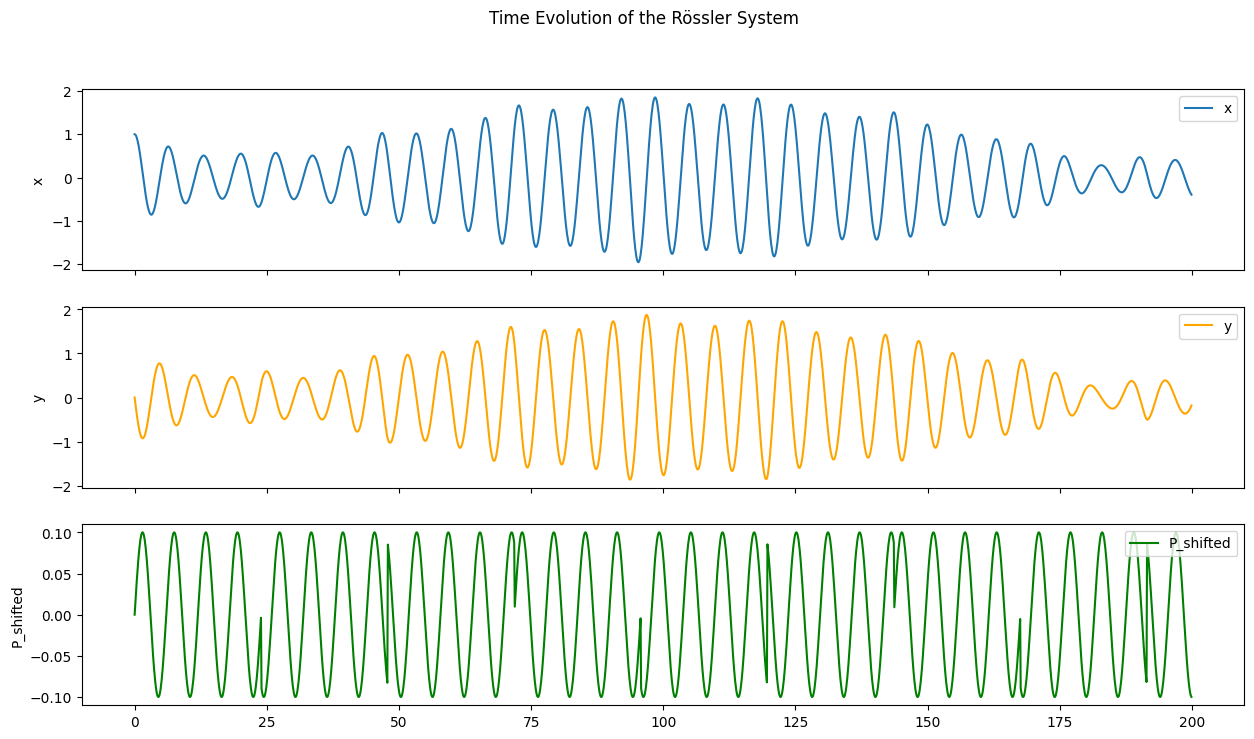

In [13]:
sample = 0
plot_length = 2000

# 時間ごとのx, y, zそれぞれのグラフ
fig, axs = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
axs[0].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['x'][sample: sample+plot_length], label='x')
axs[0].set_ylabel('x')
axs[0].legend(loc='upper right')

axs[1].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['y'][sample: sample+plot_length], label='y', color='orange')
axs[1].set_ylabel('y')
axs[1].legend(loc='upper right')

# Plot P_shifted vs. time
axs[2].plot(data_loaded_with_force['time'][sample: sample+plot_length], data_loaded_with_force['P_shifted'][sample: sample+plot_length], label='P_shifted', color='green')
axs[2].set_ylabel('P_shifted')
axs[2].legend(loc='upper right')

plt.suptitle('Time Evolution of the Rössler System')
plt.show()